In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
timeseries_df = pd.read_csv("../Project/Dataset/df_timeseries_en.tsv", sep='\t', parse_dates=["datetime"])
timeseries_df.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.000000,395.777778,6,1,1


In [3]:
channel_df = pd.read_csv("../Project/Dataset/df_channels_en.tsv", sep='\t')
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


#### Addition of new columns for future analysis 
* **cumulative views**: sum of the views gained each week with the ones obtained in the previous ones, throughout the observation period
* **delta views**: difference between the views gained each week and the ones obtained in the previous one. We note that this feature is already present in the original dataset, however the absolute values are given. For our analysis the negative sign due to drop in views has relevant significance, therefore we restore it. 


In [4]:
ts_grouped_by_channel = timeseries_df.groupby('channel')

# calculate cumulative views per channel
timeseries_df["cumviews"] = ts_grouped_by_channel["views"].cumsum()

# because negative delta views are not included in the original dataset, we recalculated them
timeseries_df["delta_views"] = ts_grouped_by_channel["views"].diff().fillna(0)

## Significative channels visualization

#### Sudden success followed by downfall

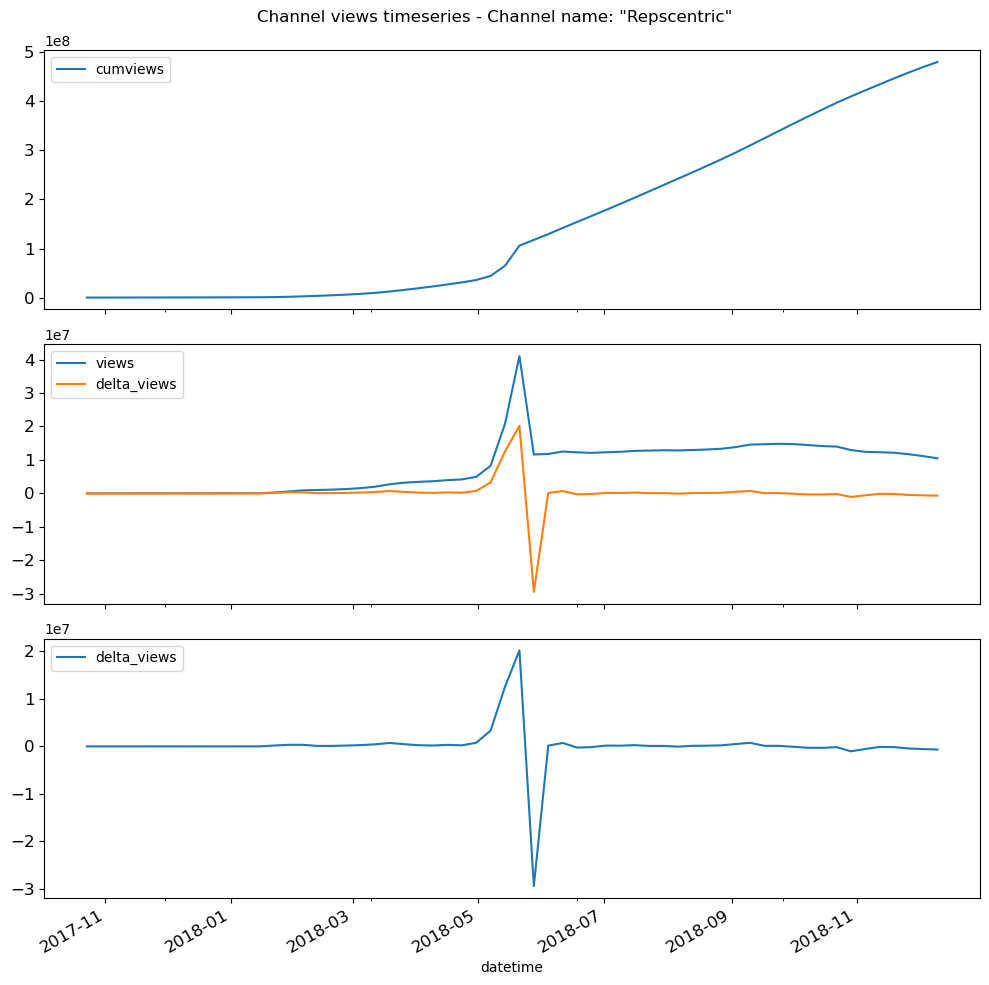

In [5]:
current_channel = 'UCj-R_ePoJvWGiLOD6aDgMSg'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

This channel is an example of a 'lose-fame' channel. We can observe that it experienced a steep growth in a relatively short period of time (less than two months), but it lost the gained views right after. Indeed, a peak in the ‘delta_views’ followed is visible, but it is followed by a sudden decrease; also, at the beginning and at the end of the observation period, the views don’t show a big variation.


#### Sudden success followed by stability

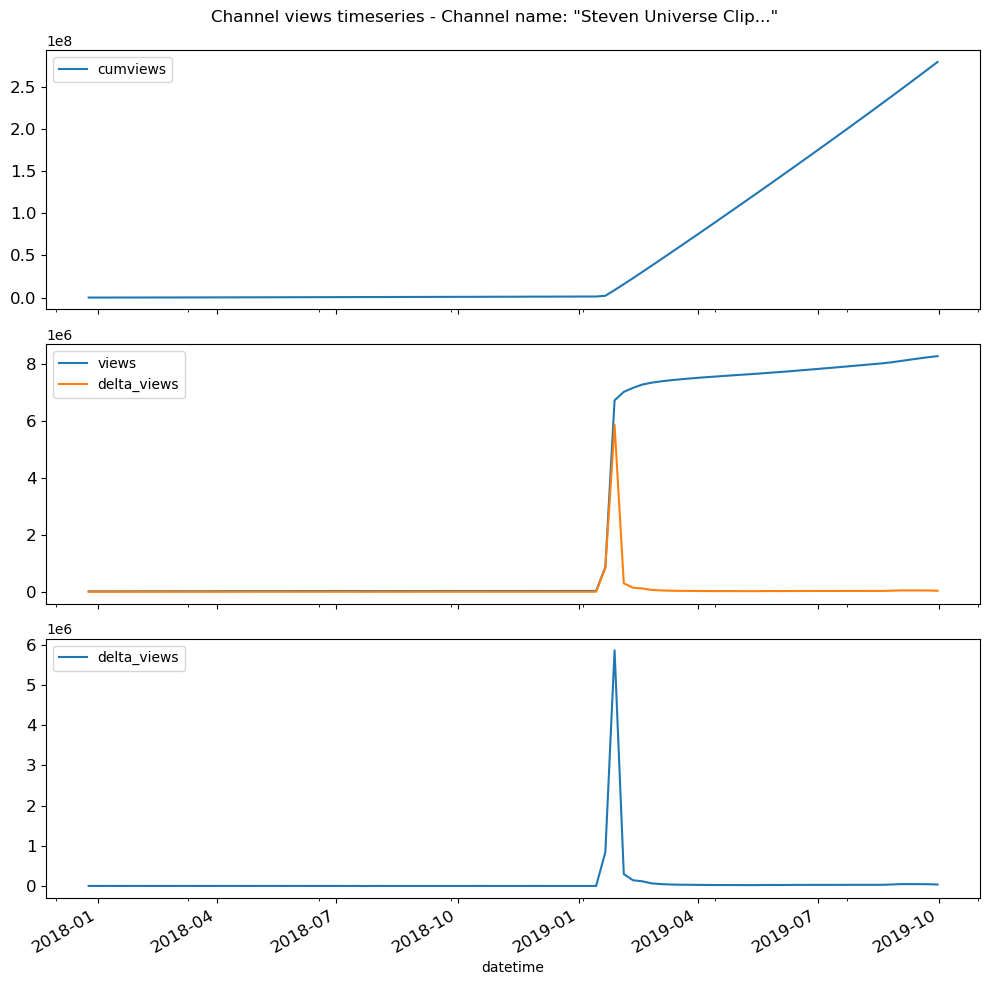

In [6]:
current_channel = 'UCa4hfBXGDC_TxUHTEbCdyng'

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs_flat = axs.ravel()

fig.suptitle(f"Channel views timeseries - Channel name: \"{channel_df[channel_df['channel'] == current_channel]['name_cc'].iloc[0]}\"")

timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="cumviews", ax=axs_flat[0], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[1], fontsize=12)
timeseries_df[timeseries_df["channel"] == current_channel].plot(x="datetime", y="delta_views", ax=axs_flat[2], fontsize=12)

for i in range(3):
    axs_flat[i].legend(loc='upper left')
plt.tight_layout()

These graphs well represent the ‘keep-fame’ population. Indeed, we can observe that, after the spike in weekly views, the channel's popularity in terms of visualizations has stabilized. It keeps having high numbers of views, significantly larger than before sudden success gain. This can also be underlined by the fact that the number of views between the beginning and the end of the time series has significantly increased.

## Population division

### Step 1: Calculate meaningful metrics

##### Metric 1: Channel growth
This metric is used as a first step to distinguish between the populations. It consists of the difference in views between the end and the beginning of the observation period for each channel normalized with respect to the initial views. It displays if the channel gained or lost views, or if they remained more or less constant.

In [7]:
begin, end = ts_grouped_by_channel['views'].first(), ts_grouped_by_channel['views'].last()

growth = (end - begin) / begin
growth.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    68.681544
UC--2EbuIuBOGgGqPiJxi3rg     1.664100
Name: views, dtype: float64

#### Metric 2: Views variability 
This metric is an indicator of the variability of the views during the observation period per channel, giving insights about the relative extent to which the visualizations varied. It is computed by making the difference between the maximum and minimum number of views, normalized with respect to the maximum.

In [8]:
max_views = ts_grouped_by_channel['views'].max()
min_views = ts_grouped_by_channel['views'].min()

variability = (max_views - min_views) / max_views
variability.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.985649
UC--2EbuIuBOGgGqPiJxi3rg    0.624639
Name: views, dtype: float64

##### Metric 3: Views growth steepness
This is a metric obtained from the maximum number of new views gained in a week with respect to the week before, divided by the maximum number of views overall. It allows to detect if the growth was steep (in other words, if the newly gained views had a significant impact on the overall views), by comparing the orders of magnitude of the two quantities.

In [9]:
delta_max = ts_grouped_by_channel["delta_views"].max()

growth_steepness = delta_max / max_views
growth_steepness.head(2)

channel
UC--24Q3_ZQeFmgJE-Um5QZQ    0.173725
UC--2EbuIuBOGgGqPiJxi3rg    0.008063
dtype: float64

In [10]:
metrics = pd.DataFrame({
    "growth_steepness": growth_steepness,
    "growth": growth,
    "variability": variability
}).reset_index()
metrics.head(2)

,channel,growth_steepness,growth,variability
0,UC--24Q3_ZQeFmgJE-Um5QZQ,0.173725,68.681544,0.985649
1,UC--2EbuIuBOGgGqPiJxi3rg,0.008063,1.664100,0.624639


In [11]:
channel_df = channel_df.merge(metrics, on="channel")
channel_df.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087,0.009504,0.734529,0.423474
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087,0.030208,32.727533,0.970351


### Step 2: Divide population using the metrics

As a second step, to identify the two populations, the first metric (“channel growth”) is employed. Having defined a threshold as 0.2, we attribute all the channels of the `‘df_channels_en.tsv.gz’` that have values between -0.2 and 0.2 to the ‘lose_fame’ group, as this indicated that, overall, throughout the observation period, they didn’t vary their views numbers. Channels who instead showed a “channel growth” above 0.2, are assigned to the ‘keep_fame’ dataframe, since they significantly increased their popularity. Lastly, channels whose views timeseries dropped, are discarded since we do not deem them relevant in our project.

In [12]:
growth_bound = 0.2

# select channels with a growth between -0.2 and 0.2
lose_fame = channel_df[(-growth_bound < channel_df["growth"]) & (channel_df["growth"] < growth_bound)]

# keep only channels with a growth greater than 0.2 because we're not interested in those who lost fame
keep_fame = channel_df[channel_df["growth"] > growth_bound]

To be computed: Further filtering of the two populations by applying thresholds to the computed metrics. Ideally we want to select channels with a high variability and a high growth steepness but, for now, ordering them by those metrics and selecting the top 300 should be a good start for an initial exploratory data analysis. 

In [13]:
keep_fame.variability.describe()

count    127795.000000
mean          0.816017
std           0.222156
min           0.166670
25%           0.684857
50%           0.924921
75%           0.993278
max           1.000000
Name: variability, dtype: float64

### Step 3: Further, and more accurate, filtering

The following cells define a function that allows further filtering of the two populations. Specifically, it identifies the instant where the channels had a sudden increase, through implementing a sliding window technique. A window of 4 weeks is defined and slid across the timeseries of every channel. A steeper growth corresponds to a greater difference from the linear interpolation between the ends of the window. Given this assumption, we compute the difference between the linear interpolation and the actual registered growth using discrete integration.  This value is then normalized with respect to the area of the mentioned linear reference, obtaining an index between 0 and 1. This metric alone is useful to find time points where the views number increases, however it doesn’t convey information about the impact of the increase with respect to the overall views magnitude. For this reason, we weight each index with a coefficient that takes into account this aspect as well. 
For every timeserie, we then take the maximum computed sudden growth index and its corresponding time point, and use it to separate each timeserie in two parts, corresponding to the periods before and after sudden growth.


In [14]:
import scipy.integrate as integrate

def growth_rate_per_channel(df_timeseries):
    sliding_window = 5

    times = []
    steepnesses = []
    max_delta = df_timeseries["views"].max() - df_timeseries["views"].min()

    for i in range(len(df_timeseries['views']) - sliding_window):
        window = df_timeseries['views'][i:i+sliding_window]
        b, e = window.iloc[0], window.iloc[-1]

        if e < b:
            continue

        line = np.array([(e - b) * j / (sliding_window - 1) + b for j in range(sliding_window)])

        # since we are measuring the sudden increase in views as an integral of the difference between the linear increase and the actual increase,
        # we have to make sure that the linear increase is above the actual increase at least at the beginning of the window
        if window.iloc[1] > line[1]:
            continue

        if integrate.simpson(line - window) > 0:
            # steepness is weighted proportionally to the relative variation in views
            window_delta = line[-1] - line[0]
            coefficent = window_delta / max_delta
            growth_steepness = integrate.simpson(np.abs(line - window)) / integrate.simpson(line) * coefficent
            
            steepnesses = steepnesses + [growth_steepness]
            times = times + [df_timeseries['datetime'].iloc[i]]

    steepnesses = steepnesses + [0]
    times = times + [df_timeseries['datetime'].iloc[0]]
    
    _max = np.argmax(steepnesses)
    return pd.Series([times[_max], steepnesses[_max]])

<span style="color:red"> non eseguire! sort by variability non va bene per selezionare i primi 300 

In [15]:
aaaaa =
initial_exploration_batch_size = 300
keep_fame = keep_fame.sort_values(by=["variability", "growth_steepness"], ascending=False)
lose_fame = lose_fame.sort_values(by=["variability", "growth_steepness"], ascending=False)

# calculate the sudden increase in views for each channel
keep_fame_ts = timeseries_df[timeseries_df["channel"].isin(keep_fame[:initial_exploration_batch_size]["channel"])]
keep_fame_sudden_growth = (
    keep_fame_ts.groupby('channel')
                .apply(growth_rate_per_channel)
                .rename(columns={0: 'sudden_growth_date', 1: 'sudden_growth_index'})
                .reset_index()
)

lose_fame_ts = timeseries_df[timeseries_df["channel"].isin(lose_fame[:initial_exploration_batch_size]["channel"])]
lose_fame_sudden_growth = (
    lose_fame_ts.groupby('channel')
                .apply(growth_rate_per_channel)
                .rename(columns={0: 'sudden_growth_date', 1: 'sudden_growth_index'})
                .reset_index()
)

SyntaxError: invalid syntax (2442597882.py, line 1)

To be computed: As above, we want to analyze the channels comparing them by growth steepness, so further filtering using the new calculated metric should be done to additionally narrow the populations.

In [ ]:
keep_fame_sudden_growth.sort_values(by="sudden_growth_index", ascending=False).head(2)

,channel,sudden_growth_date,sudden_growth_index
172,UCa_rA5IqSPbspXiQ2vMaqzg,2017-09-25 00:00:00,0.374690
150,UCXQApb7rBnAf4v1OVcURVZg,2018-12-16 23:00:00,0.257213


In [ ]:
lose_fame_sudden_growth.sort_values(by="sudden_growth_index", ascending=False).head(2)

,channel,sudden_growth_date,sudden_growth_index
274,UCt6312GrcwhQAM6e1YeUpeg,2019-02-24 23:00:00,0.397577
224,UCjbxW2ALvM4jUPCp4dFXp5Q,2018-03-04 23:00:00,0.358862


### Step 4: Addition of new computed features to the original dataframe

In [ ]:
keep_fame = keep_fame.merge(keep_fame_sudden_growth, on="channel")
keep_fame.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,sudden_growth_date_x,sudden_growth_index_x,keep_fame,sudden_growth_date_y,sudden_growth_index_y,sudden_growth_date,sudden_growth_index
0,Gaming,2014-11-04,UCbryQohbzrShHSYZRTZeZCQ,Naddition,417351,133,41048.0,3.3705,0.044449,5.125606e+07,1.0,2018-05-14,0.016869,1,2018-05-14,0.016869,2018-05-14,0.016869
1,Comedy,2015-08-30,UC_lP3AW1k_M6rbwOb907fEA,Miniklin,328007,199,49504.0,3.3670,0.075339,2.973497e+07,1.0,2017-07-10,0.029875,1,2017-07-10,0.029875,2017-07-10,0.029875


In [ ]:
lose_fame = lose_fame.merge(lose_fame_sudden_growth, on="channel")
lose_fame.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,sudden_growth_date,sudden_growth_index
0,Film and Animation,2013-09-17,UCyWNMO6vPhIJYI-D7iMvIeg,AllyJessaProductions...,16631,1602,682112.0,8.9455,0.033762,-0.160153,0.941999,2016-12-18 23:00:00,0.001843
1,Film and Animation,2012-08-02,UC-ffP6LXdomMljpS13j1CfQ,UnsignedMusicz,69600,22,223924.0,6.6170,0.051647,-0.167558,0.932202,2017-08-28 00:00:00,0.004229


In [ ]:
keep_fame_ts = keep_fame_ts.merge(keep_fame[["channel", "sudden_growth_date"]], on="channel")
lose_fame_ts = lose_fame_ts.merge(lose_fame[["channel", "sudden_growth_date"]], on="channel")

In [ ]:
keep_fame_ts_after_sudden_growth = keep_fame_ts[keep_fame_ts["datetime"] > keep_fame_ts["sudden_growth_date"]]
lose_fame_ts_after_sudden_growth = lose_fame_ts[lose_fame_ts["datetime"] > lose_fame_ts["sudden_growth_date"]]

In [ ]:
lose_fame_ts_after_sudden_growth.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,cumviews,sudden_growth_date
146,UCCchCB5_SWZYK57nb1sXuUg,People & Blogs,2019-04-15,1.653814e+06,86859.402778,94261.333333,5064.083333,19,1,1,3.728268e+08,2019-04-08
147,UCCchCB5_SWZYK57nb1sXuUg,People & Blogs,2019-04-22,1.786843e+06,133029.000000,100874.555556,6613.222222,20,1,2,3.746136e+08,2019-04-08


### Step 5: Initial statistical analysis
This step shows the beginning of the statistical investigation of the two populations

In [ ]:
keep_fame_mean_videos = keep_fame_ts_after_sudden_growth.groupby("channel")["delta_videos"].mean()
lose_fame_mean_videos = lose_fame_ts_after_sudden_growth.groupby("channel")["delta_videos"].mean()

print(f"Keep-fame mean weekly videos: {keep_fame_mean_videos.mean()}")
print(f"Lose-fame mean weekly videos: {lose_fame_mean_videos.mean()}")
scs.ttest_ind(keep_fame_mean_videos, lose_fame_mean_videos)

Keep-fame mean weekly videos: 3.9189317905019196
Lose-fame mean weekly videos: 1.494064819549593


Ttest_indResult(statistic=3.2554006875604258, pvalue=0.0011962954473883386)

In [ ]:
keep_fame_mean_weekly_subs = keep_fame_ts_after_sudden_growth.groupby("channel")["delta_subs"].mean()
lose_fame_mean_weekly_subs = lose_fame_ts_after_sudden_growth.groupby("channel")["delta_subs"].mean()

print(f"Keep-fame mean weekly subs: {keep_fame_mean_weekly_subs.mean()}")
print(f"Lose-fame mean weekly subs: {lose_fame_mean_weekly_subs.mean()}")
scs.ttest_ind(keep_fame_mean_weekly_subs, lose_fame_mean_weekly_subs)

Keep-fame mean weekly subs: 13748.568802747726
Lose-fame mean weekly subs: 1124.3071435678637


Ttest_indResult(statistic=7.046511621629891, pvalue=5.069933435374548e-12)

### Step 6: Initial analysis using video metadata
Video metatada will be useful in the final analysis. Here we start to make a few observations and statistical tests to explore the data.

In [ ]:
videos_df = pd.read_feather("C:/dev/repos/ada_project/data/yt_metadata_helper.feather", columns=["channel_id", "duration", "upload_date", "like_count", "dislike_count", "view_count"])
videos_df["upload_date"] = pd.to_datetime(videos_df["upload_date"])
videos_df = videos_df.rename({'channel_id': 'channel'}, axis=1)

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

In [ ]:
keep_fame_video_df = videos_df.merge(keep_fame[["channel", "sudden_growth_date"]], on="channel")
lose_fame_video_df = videos_df.merge(lose_fame[["channel", "sudden_growth_date"]], on="channel")

In [ ]:
keep_fame_videos_after_sudden_growth = keep_fame_video_df[keep_fame_video_df["upload_date"] > keep_fame_video_df["sudden_growth_date"]].copy()
lose_fame_videos_after_sudden_growth = lose_fame_video_df[lose_fame_video_df["upload_date"] > lose_fame_video_df["sudden_growth_date"]].copy()

In [ ]:
keep_fame_video_mean_duration = keep_fame_videos_after_sudden_growth.groupby("channel")["duration"].mean()
lose_fame_video_mean_duration = lose_fame_videos_after_sudden_growth.groupby("channel")["duration"].mean()

print(f"Keep-fame videos mean duration: {keep_fame_video_mean_duration.mean()}")
print(f"Lose-fame videos mean duration: {lose_fame_video_mean_duration.mean()}")
scs.ttest_ind(keep_fame_video_mean_duration, lose_fame_video_mean_duration)

Keep-fame videos mean duration: 691.794142567787
Lose-fame videos mean duration: 815.2214385162331


Ttest_indResult(statistic=-1.0091796785643594, pvalue=0.3133035678417406)

In [ ]:
keep_fame_videos_after_sudden_growth["like_views_ratio"] = keep_fame_videos_after_sudden_growth["like_count"] / keep_fame_videos_after_sudden_growth["view_count"]
lose_fame_videos_after_sudden_growth["like_views_ratio"] = lose_fame_videos_after_sudden_growth["like_count"] / lose_fame_videos_after_sudden_growth["view_count"]


keep_fame_like_views_ratio = keep_fame_videos_after_sudden_growth.groupby("channel")["like_views_ratio"].mean()
lose_fame_like_views_ratio = lose_fame_videos_after_sudden_growth.groupby("channel")["like_views_ratio"].mean()

print(f"Keep-fame videos like/views ratio: {keep_fame_like_views_ratio.mean()}")
print(f"Lose-fame videos like/views ratio: {lose_fame_like_views_ratio.mean()}")
scs.ttest_ind(keep_fame_like_views_ratio, lose_fame_like_views_ratio)

Keep-fame videos like/views ratio: 0.022791012254978427
Lose-fame videos like/views ratio: 0.03519624328488959


Ttest_indResult(statistic=nan, pvalue=nan)

In [ ]:
keep_fame_videos_after_sudden_growth["dislike_views_ratio"] = keep_fame_videos_after_sudden_growth["dislike_count"] / keep_fame_videos_after_sudden_growth["view_count"]
lose_fame_videos_after_sudden_growth["dislike_views_ratio"] = lose_fame_videos_after_sudden_growth["dislike_count"] / lose_fame_videos_after_sudden_growth["view_count"]


keep_fame_dislike_views_ratio = keep_fame_videos_after_sudden_growth.groupby("channel")["dislike_views_ratio"].mean()
lose_fame_dislike_views_ratio = lose_fame_videos_after_sudden_growth.groupby("channel")["dislike_views_ratio"].mean()

print(f"Keep-fame videos dislike/views ratio: {keep_fame_dislike_views_ratio.mean()}")
print(f"Lose-fame videos dislike/views ratio: {lose_fame_dislike_views_ratio.mean()}")
scs.ttest_ind(keep_fame_dislike_views_ratio, lose_fame_dislike_views_ratio)

Keep-fame videos dislike/views ratio: 0.001414842106005023
Lose-fame videos dislike/views ratio: 0.002022437491634156


Ttest_indResult(statistic=nan, pvalue=nan)

#### Step 7: Propensity scores

In [16]:
lose_fame = lose_fame.copy()
keep_fame = keep_fame.copy()
lose_fame["keep_fame"] = 0
keep_fame["keep_fame"] = 1

In [17]:
channels_filtered_df = pd.concat([lose_fame, keep_fame])
channels_filtered_df["category_cc"] = channels_filtered_df["category_cc"].str.replace(" & ", "_").str.replace(" ", "_")
channels_filtered_df = pd.get_dummies(channels_filtered_df, columns=["category_cc"], dtype=int)
channels_filtered_df.head(2)


,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,...,category_cc_Gaming,category_cc_Howto_Style,category_cc_Music,category_cc_News_Politics,category_cc_Nonprofits_Activism,category_cc_People_Blogs,category_cc_Pets_Animals,category_cc_Science_Technology,category_cc_Sports,category_cc_Travel_Events
5,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087,0.007550,0.133989,0.118157,...,0,0,0,0,0,0,0,0,0,0
15,2008-06-01,UCYvmuw-JtVrTZQ-7Y4kd63Q,Katy Perry,35028528,101,30.0,2.087,0.047522,0.138656,0.121772,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# drop_cols = channels_filtered_df.columns.drop(['join_date', 'channel', 'name_cc', 'growth', 'sudden_growth_date', 'keep_fame'])
drop_cols = channels_filtered_df.columns.drop(['join_date', 'channel', 'name_cc', 'growth', 'keep_fame','variability'])
regressors = str.join(' + ', drop_cols.to_list())

In [19]:
channels_filtered_df.dtypes

join_date                           object
channel                             object
name_cc                             object
subscribers_cc                       int64
videos_cc                            int64
subscriber_rank_sb                 float64
weights                            float64
growth_steepness                   float64
growth                             float64
variability                        float64
keep_fame                            int64
category_cc_Autos_Vehicles           int32
category_cc_Comedy                   int32
category_cc_Education                int32
category_cc_Entertainment            int32
category_cc_Film_and_Animation       int32
category_cc_Gaming                   int32
category_cc_Howto_Style              int32
category_cc_Music                    int32
category_cc_News_Politics            int32
category_cc_Nonprofits_Activism      int32
category_cc_People_Blogs             int32
category_cc_Pets_Animals             int32
category_cc

In [20]:
regressors

'subscribers_cc + videos_cc + subscriber_rank_sb + weights + growth_steepness + category_cc_Autos_Vehicles + category_cc_Comedy + category_cc_Education + category_cc_Entertainment + category_cc_Film_and_Animation + category_cc_Gaming + category_cc_Howto_Style + category_cc_Music + category_cc_News_Politics + category_cc_Nonprofits_Activism + category_cc_People_Blogs + category_cc_Pets_Animals + category_cc_Science_Technology + category_cc_Sports + category_cc_Travel_Events'

In [21]:
channels_filtered_df[drop_cols] = channels_filtered_df[drop_cols] - channels_filtered_df[drop_cols].mean()
channels_filtered_df[drop_cols] = channels_filtered_df[drop_cols] / channels_filtered_df[drop_cols].std()

In [22]:
channels_filtered_df[drop_cols].describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,category_cc_Autos_Vehicles,category_cc_Comedy,category_cc_Education,category_cc_Entertainment,category_cc_Film_and_Animation,category_cc_Gaming,category_cc_Howto_Style,category_cc_Music,category_cc_News_Politics,category_cc_Nonprofits_Activism,category_cc_People_Blogs,category_cc_Pets_Animals,category_cc_Science_Technology,category_cc_Sports,category_cc_Travel_Events
count,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05,1.324440e+05
mean,5.219098e-15,-1.862970e-16,-6.389488e-15,3.798585e-16,-1.032097e-16,2.443031e-14,-4.490825e-14,7.232842e-15,-1.642866e-14,-2.009715e-14,-2.231709e-14,-3.239122e-14,9.482369e-15,-9.989043e-15,1.634796e-14,3.327709e-14,3.878941e-15,8.767675e-15,1.103327e-14,3.818448e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.053796e-01,-1.593110e-01,-1.316039e+00,-9.995122e-01,-7.962704e-01,-1.670110e-01,-1.680114e-01,-2.465057e-01,-4.492525e-01,-2.298303e-01,-4.163742e-01,-3.090768e-01,-4.658580e-01,-1.302064e-01,-8.490754e-02,-3.945572e-01,-9.772864e-02,-1.921085e-01,-1.975158e-01,-1.221465e-01
25%,-1.976736e-01,-1.453599e-01,-8.884315e-01,-5.921776e-01,-5.362596e-01,-1.670110e-01,-1.680114e-01,-2.465057e-01,-4.492525e-01,-2.298303e-01,-4.163742e-01,-3.090768e-01,-4.658580e-01,-1.302064e-01,-8.490754e-02,-3.945572e-01,-9.772864e-02,-1.921085e-01,-1.975158e-01,-1.221465e-01
50%,-1.772398e-01,-1.207131e-01,-2.058176e-01,-1.709543e-01,-3.277276e-01,-1.670110e-01,-1.680114e-01,-2.465057e-01,-4.492525e-01,-2.298303e-01,-4.163742e-01,-3.090768e-01,-4.658580e-01,-1.302064e-01,-8.490754e-02,-3.945572e-01,-9.772864e-02,-1.921085e-01,-1.975158e-01,-1.221465e-01
75%,-9.541779e-02,-5.793347e-02,7.833873e-01,3.609018e-01,1.225194e-01,-1.670110e-01,-1.680114e-01,-2.465057e-01,-4.492525e-01,-2.298303e-01,-4.163742e-01,-3.090768e-01,-4.658580e-01,-1.302064e-01,-8.490754e-02,-3.945572e-01,-9.772864e-02,-1.921085e-01,-1.975158e-01,-1.221465e-01
max,9.688090e+01,7.719754e+01,2.488978e+00,8.715638e+00,1.634773e+01,5.987583e+00,5.951930e+00,4.056671e+00,2.225903e+00,4.351004e+00,2.401668e+00,3.235418e+00,2.146561e+00,7.680055e+00,1.177743e+01,2.534468e+00,1.023234e+01,5.205351e+00,5.062847e+00,8.186828e+00


In [23]:
import statsmodels.formula.api as smf

res = smf.logit(formula=f"""keep_fame ~  {regressors}""", data=channels_filtered_df).fit()
# res = smf.logit(formula=f"""keep_fame ~ variability""", data=channels_filtered_df).fit(maxiter=1000)

# Extract the estimated propensity scores
# channels_filtered_df['Propensity_score'] = res.predict()
propensity_score = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.142313
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              keep_fame   No. Observations:               132444
Model:                          Logit   Df Residuals:                   132423
Method:                           MLE   Df Model:                           20
Date:                Wed, 07 Dec 2022   Pseudo R-squ.:                 0.06405
Time:                        15:58:15   Log-Likelihood:                -18848.
converged:                       True   LL-Null:                       -20138.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           3.9201      0.028    138.292 

In [26]:
channels_filtered_df["prop_score"] = pd.Series(propensity_score)
channels_filtered_df.head(2)

,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,...,category_cc_Howto_Style,category_cc_Music,category_cc_News_Politics,category_cc_Nonprofits_Activism,category_cc_People_Blogs,category_cc_Pets_Animals,category_cc_Science_Technology,category_cc_Sports,category_cc_Travel_Events,prop_score
5,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,40.111710,-0.130479,-1.316005,-0.999417,-0.666545,0.133989,0.118157,...,-0.309077,-0.465858,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,-0.197516,-0.122147,0.913268
15,2008-06-01,UCYvmuw-JtVrTZQ-7Y4kd63Q,Katy Perry,30.115094,-0.138152,-1.315939,-0.999417,0.020237,0.138656,0.121772,...,-0.309077,-0.465858,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,-0.197516,-0.122147,0.999767


In [28]:
keep = channels_filtered_df[channels_filtered_df["keep_fame"] == 1]
lose = channels_filtered_df[channels_filtered_df["keep_fame"] == 0]
display(keep.sort_values("prop_score", ascending=False).head(2))
display(lose.sort_values("prop_score", ascending=False).head(2))

,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,...,category_cc_Howto_Style,category_cc_Music,category_cc_News_Politics,category_cc_Nonprofits_Activism,category_cc_People_Blogs,category_cc_Pets_Animals,category_cc_Science_Technology,category_cc_Sports,category_cc_Travel_Events,prop_score
116660,2008-11-21,UCReG_xJuKb9h3uUHn0_jKog,SXCC - Shot by Cleva...,-0.204947,-0.009802,1.395799,0.561810,-0.175521,62.442024,0.984238,...,-0.309077,2.146561,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,-0.197516,-0.122147,1.0
95969,2012-12-05,UCAir8kj7mB29apKZ53ryKKw,KingsDreamENT,-0.194730,-0.118620,0.634641,0.560574,-0.590929,2.888766,0.742849,...,-0.309077,2.146561,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,-0.197516,-0.122147,1.0


,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,growth_steepness,growth,variability,...,category_cc_Howto_Style,category_cc_Music,category_cc_News_Politics,category_cc_Nonprofits_Activism,category_cc_People_Blogs,category_cc_Pets_Animals,category_cc_Science_Technology,category_cc_Sports,category_cc_Travel_Events,prop_score
30392,2008-07-21,UCzYOUL6lSyW2vLKiDRf5xkQ,Lucky Scooters Offic...,-0.064248,-0.060259,-0.942554,-0.692917,-0.714217,0.128732,0.114050,...,-0.309077,-0.465858,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,5.062847,-0.122147,1.0
131311,2006-11-19,UCN-lZDiEAOPlOsbrZbFgCFg,mepi.pl,-0.204548,-0.088393,2.079818,2.146820,-0.531270,0.128999,0.215552,...,-0.309077,-0.465858,-0.130206,-0.084908,-0.394557,-0.097729,-0.192109,-0.197516,-0.122147,1.0
